# OBJECTIVE 

Understanding user behavior through implicit signals like clicks and views is crucial for building effective recommender systems in real-world e-commerce platforms. Being able to predict preferences from limited interaction data helps personalize user experience, boosting engagement and conversions. Simultaneously, detecting and removing abnormal traffic is essential to ensure the recommendations are based on genuine customer behavior and do not suffer from noise or bias—leading to better decision-making and higher ROI for businesses.

Can we accurately predict item properties associated with “addtocart” events based on a visitor’s prior “view” behavior, and can we detect and filter out abnormal user activity to improve the performance of recommender systems?

In [2]:
# Lets import the necessary libraries 
import pandas as pd
import numpy as np
import time

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, f1_score

# Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# LOADING DATA

The data will be sourced from the publicly available RetailRocket Recommender System Dataset
https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset which includes:
 events.csv – records user interactions (view, add to cart, transaction)
 item_properties_part1.csv and item_properties_part2.csv – describe time-stamped item properties
 category_tree.csv – describes the hierarchical relationships between product categories

In [4]:
event_data = pd.read_csv('data/events.csv')
category_data = pd.read_csv('data/category_tree.csv')
item_data = pd.concat([pd.read_csv('data/item_properties_part1.csv'),pd.read_csv('data/item_properties_part2.csv')])

print("Here are the number of records in each file")
print("Events shape:", event_data.shape)
print("Category tree shape:", category_data.shape)
print("Item properties shape:", item_data.shape)

Here are the number of records in each file
Events shape: (2756101, 5)
Category tree shape: (1669, 2)
Item properties shape: (20275902, 4)


# EXPLORATORY DATA ANALYSIS (EDA)

In [6]:
event_data['timestamp'] = pd.to_datetime(event_data['timestamp'], unit='ms')
event_data.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [7]:
event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB


In [8]:
event_data.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [9]:
# Drop Duplicate entiries
event_data.duplicated().sum()
event_data.drop_duplicates(inplace=True)

460

In [13]:
print("Events shape:", event_data.shape)

Events shape: (2755641, 5)


In [14]:
print('Number of unique visitors = {:,}'.format(len(event_data['visitorid'].unique())))
print('Number of unique items = {:,}'.format(len(event_data['itemid'].unique())))
print('Number of unique transactions = {:,}'.format(len(event_data['transactionid'].unique())))

Number of unique visitors = 1,407,580
Number of unique items = 235,061
Number of unique transactions = 17,673


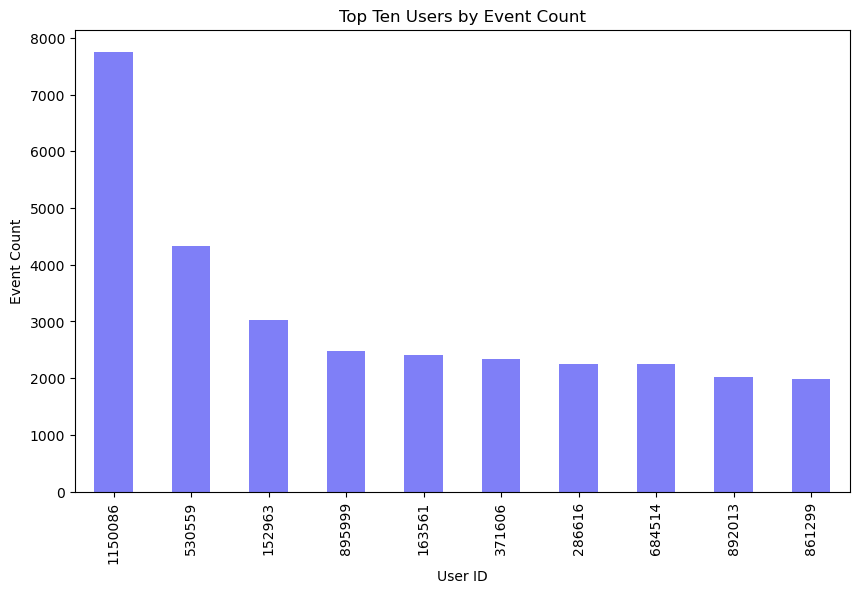

In [15]:
user_count= event_data['visitorid'].value_counts()
top_ten_users= user_count.head(10)

plt.figure(figsize=(10, 6))
top_ten_users.plot(kind='bar',color='#0000F080')
plt.title('Top Ten Users by Event Count')
plt.xlabel('User ID')
plt.ylabel('Event Count')
plt.savefig("images/Top_ten_Users.png")

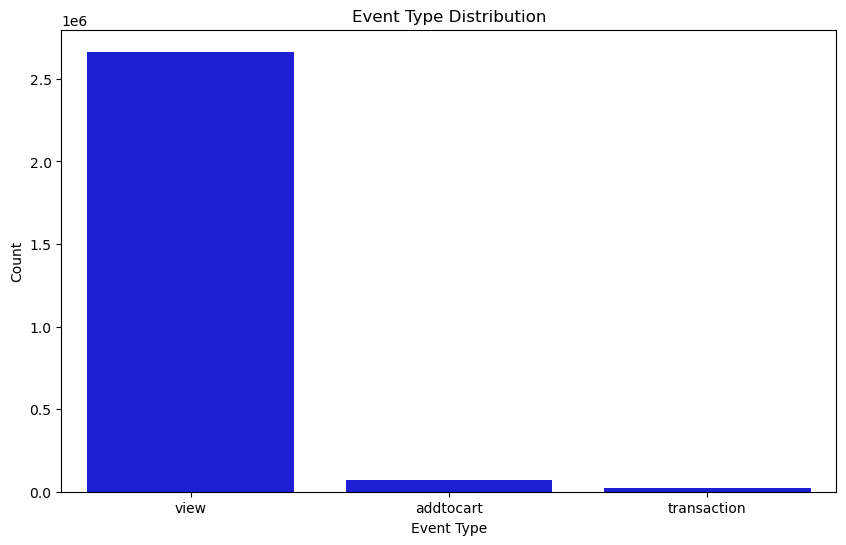

In [16]:
event_counts = event_data['event'].value_counts()

# Visualize with a countplot
plt.figure(figsize=(10,6))
sns.countplot(x='event', data=event_data, order=event_counts.index, color='#0000F080')
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.savefig("images/Event_type_count.png")
plt.show()

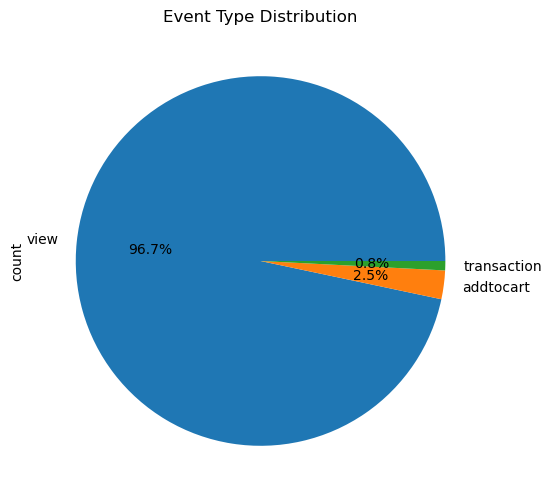

In [17]:
plt.figure(figsize=(10, 6))
event_percentage = (event_counts / len(event_data)) * 100
event_percentage.plot(kind='pie',autopct='%1.1f%%')
plt.title('Event Type Distribution')
plt.savefig("images/Event_tupe_pie.png")
plt.show()

Only 0.8% of the views are converted into purchases and 2.5% result in add to cart

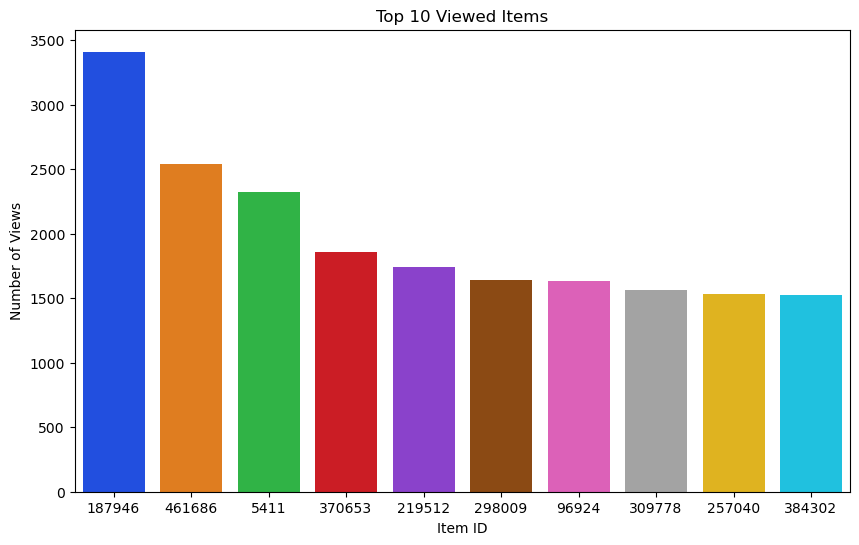

In [19]:
# plot top 10 views item
top_viewed_items = event_data[event_data['event'] == 'view']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values, order=top_viewed_items.index,palette="bright")
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.savefig("images/Top_ten_Viewed_Items.png")
plt.show()

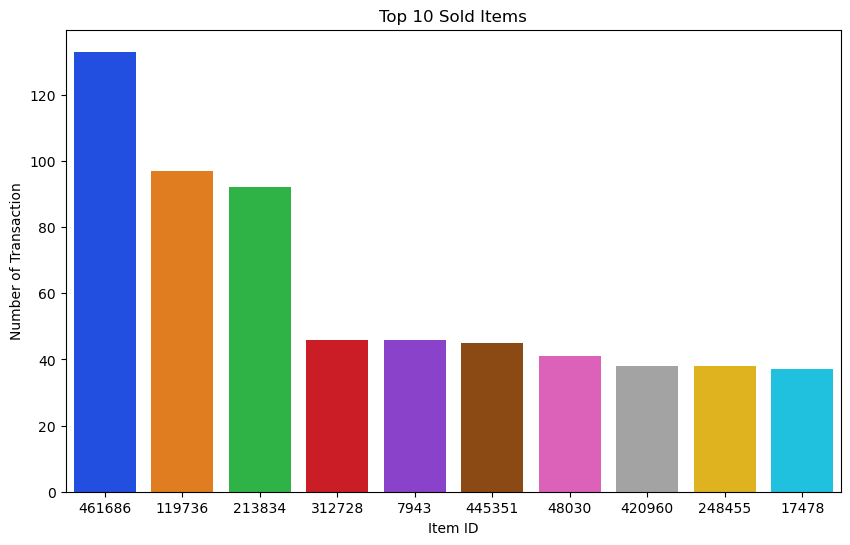

In [20]:
# plot top 10 transaction item
top_sold_items = event_data[event_data['event'] == 'transaction']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values,order=top_sold_items.index, palette="bright")
plt.title('Top 10 Sold Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Transaction')
plt.savefig("images/Top_ten_sold_items.png")
plt.show()

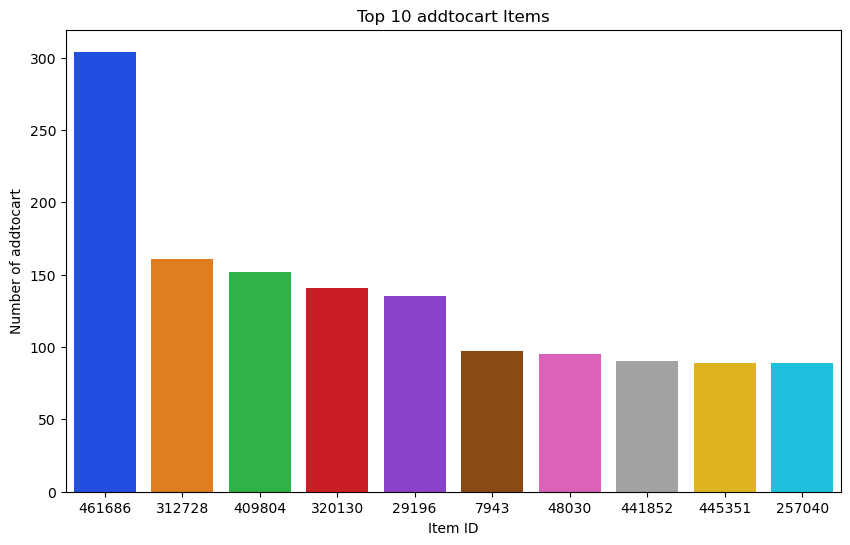

In [21]:
top_atc_items = event_data[event_data['event'] == 'addtocart']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_atc_items.index, y=top_atc_items.values, order=top_atc_items.index, palette="bright")
plt.title('Top 10 addtocart Items')
plt.xlabel('Item ID')
plt.ylabel('Number of addtocart')
plt.savefig("images/Top_ten_Items_AddedtoCart.png")
plt.show()

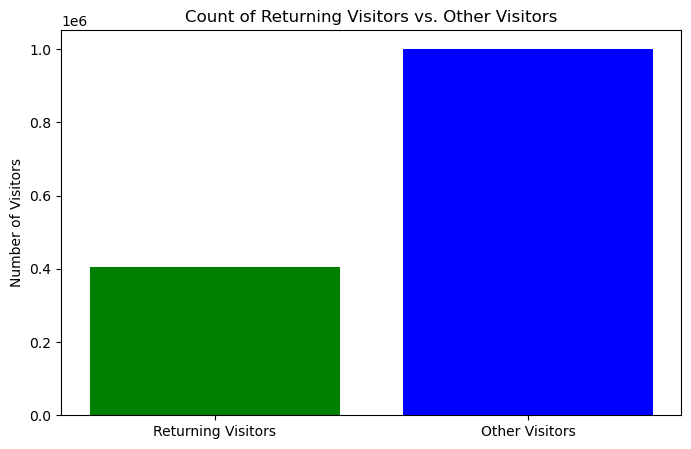

In [22]:
# Calculate the number of events per visitor
events_per_visitor = event_data.groupby('visitorid')['event'].count().reset_index()
events_per_visitor.columns = ['visitorid', 'num_events']

# Identify returning visitors (those with more than one event)
returning_visitors = events_per_visitor[events_per_visitor['num_events'] > 1]

# Plot the count of returning visitors
plt.figure(figsize=(8, 5))
plt.bar(['Returning Visitors', 'Other Visitors'], [len(returning_visitors), len(events_per_visitor) - len(returning_visitors)], color=['green', 'blue'])
plt.title('Count of Returning Visitors vs. Other Visitors')
plt.ylabel('Number of Visitors')
plt.savefig("images/ReturningUsersvsNew.png")

Lets build a base model

In [24]:
event_data['converted'] = event_data['transactionid'].notna().astype(int)

In [48]:
event_data

,timestamp,visitorid,event,itemid,transactionid,converted
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,0
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,0
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,0
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,0
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,0
...,...,...,...,...,...,...
2756096,2015-08-01 03:13:05.939,591435,view,261427,NaN,0
2756097,2015-08-01 03:30:13.142,762376,view,115946,NaN,0
2756098,2015-08-01 02:57:00.527,1251746,view,78144,NaN,0
2756099,2015-08-01 03:08:50.703,1184451,view,283392,NaN,0


In [52]:
# Creating and Filtering data related to our Context, to perform Model Training
visitor_data = event_data.groupby('visitorid').agg(
    views=('itemid', 'count'),  # Number of views
    first_view=('timestamp', 'min'),  # Time of first viewing
    last_view=('timestamp', 'max'),  # Time of last viewing
    converted=('converted', 'max')  # If they purchased
).reset_index()

In [54]:
visitor_data

,visitorid,views,first_view,last_view,converted
0,0,3,2015-09-11 20:49:49.439,2015-09-11 20:55:17.175,0
1,1,1,2015-08-13 17:46:06.444,2015-08-13 17:46:06.444,0
2,2,8,2015-08-07 17:51:44.567,2015-08-07 18:20:57.845,0
3,3,1,2015-08-01 07:10:35.296,2015-08-01 07:10:35.296,0
4,4,1,2015-09-15 21:24:27.167,2015-09-15 21:24:27.167,0
...,...,...,...,...,...
1407575,1407575,1,2015-06-10 21:46:08.922,2015-06-10 21:46:08.922,0
1407576,1407576,1,2015-06-03 15:01:29.991,2015-06-03 15:01:29.991,0
1407577,1407577,1,2015-05-17 21:48:04.867,2015-05-17 21:48:04.867,0
1407578,1407578,1,2015-05-17 01:21:23.288,2015-05-17 01:21:23.288,0


In [56]:
# Calculating the difference between the first and last view
visitor_data['view_time_diff'] = (visitor_data['last_view'] - visitor_data['first_view']).dt.total_seconds()

In [58]:
visitor_data

,visitorid,views,first_view,last_view,converted,view_time_diff
0,0,3,2015-09-11 20:49:49.439,2015-09-11 20:55:17.175,0,327.736
1,1,1,2015-08-13 17:46:06.444,2015-08-13 17:46:06.444,0,0.000
2,2,8,2015-08-07 17:51:44.567,2015-08-07 18:20:57.845,0,1753.278
3,3,1,2015-08-01 07:10:35.296,2015-08-01 07:10:35.296,0,0.000
4,4,1,2015-09-15 21:24:27.167,2015-09-15 21:24:27.167,0,0.000
...,...,...,...,...,...,...
1407575,1407575,1,2015-06-10 21:46:08.922,2015-06-10 21:46:08.922,0,0.000
1407576,1407576,1,2015-06-03 15:01:29.991,2015-06-03 15:01:29.991,0,0.000
1407577,1407577,1,2015-05-17 21:48:04.867,2015-05-17 21:48:04.867,0,0.000
1407578,1407578,1,2015-05-17 01:21:23.288,2015-05-17 01:21:23.288,0,0.000


In [60]:
# Define X and y
X = visitor_data[['views', 'view_time_diff']]  
y = visitor_data['converted']  

In [62]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [79]:
# Lets use a LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [81]:
y_pred_lr = lr_model.predict(X_test)
y_pred_lr_bin = (y_pred_lr > 0.5).astype(int)

In [83]:
accuracy_lr = accuracy_score(y_test, y_pred_lr_bin)
precision_lr = precision_score(y_test, y_pred_lr_bin)
recall_lr = recall_score(y_test, y_pred_lr_bin)
f1_lr = f1_score(y_test, y_pred_lr_bin)

print("Linear Regression: ")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

Linear Regression: 
Accuracy: 0.9916
Precision: 0.8125
Recall: 0.0055
F1-Score: 0.0109


In [66]:
# Next lets use a RandomForest Model 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [68]:
y_pred_rf = rf_model.predict(X_test)

In [70]:
# Calculate the metrics for Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print("\nRandom Forest:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")


Random Forest:
Accuracy: 0.9870
Precision: 0.1235
Recall: 0.0897
F1-Score: 0.1040


In [91]:
def plot_confusion_matrix(model, X_test, y_test, model_name, threshold=0.5):
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Not Converted', 'CConverted'], yticklabels=['Not Converted', 'CConverted'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'images/{model_name}.png')
    plt.show()

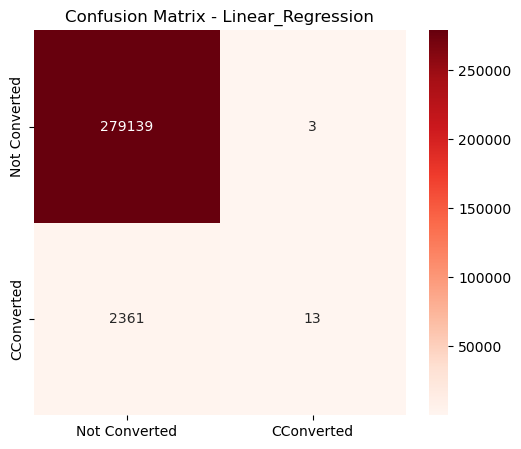

In [93]:
plot_confusion_matrix(lr_model, X_test, y_test, "Linear_Regression")

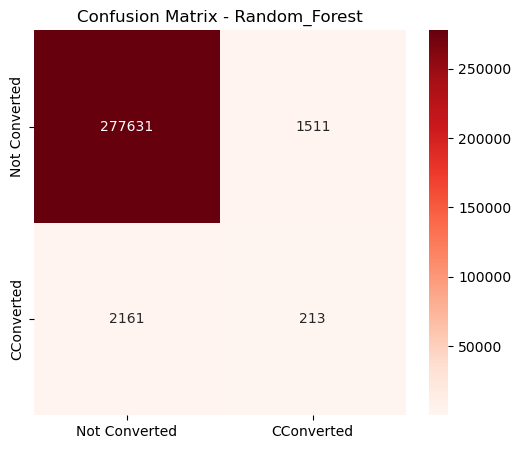

In [95]:
plot_confusion_matrix(rf_model, X_test, y_test, "Random_Forest")